In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from scipy.stats import ttest_1samp

In [ ]:
input_file = '/content/chatgpt_sentiment.csv'
daily_output_file = '/content/daily_avg_sentiment.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file)

In [ ]:
# Calculate sentiment score for each row (sentiment score = positive - negative)
df['sentiment score'] = df['positive'] - df['negative']

# Convert the "date" column to a datetime type (adjust format if needed)
df['date'] = pd.to_datetime(df['date'])

# Group the DataFrame by date (ignoring the time portion) and compute the average sentiment score
daily_avg = df.groupby(df['date'].dt.date)['sentiment score'].mean().reset_index()

# Rename the columns for clarity
daily_avg.columns = ['date', 'average sentiment score']

# Save the resulting daily average sentiment scores to a new CSV file
daily_avg.to_csv(daily_output_file, index=False)

print(f"Daily average sentiment scores have been saved to: {daily_output_file}")

Daily average sentiment scores have been saved to: /content/daily_avg_sentiment.csv


<Figure size 1200x600 with 0 Axes>

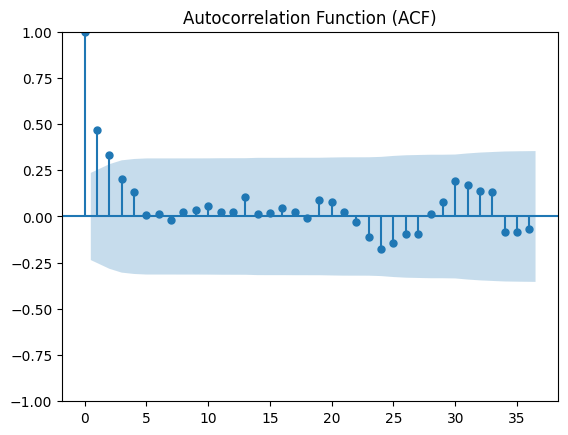

In [ ]:
daily_output_file = '/content/daily_avg_sentiment.csv'
df2 = pd.read_csv(daily_output_file)

plt.figure(figsize=(12, 6))
plot_acf(df2['average sentiment score'], lags=36, title='Autocorrelation Function (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

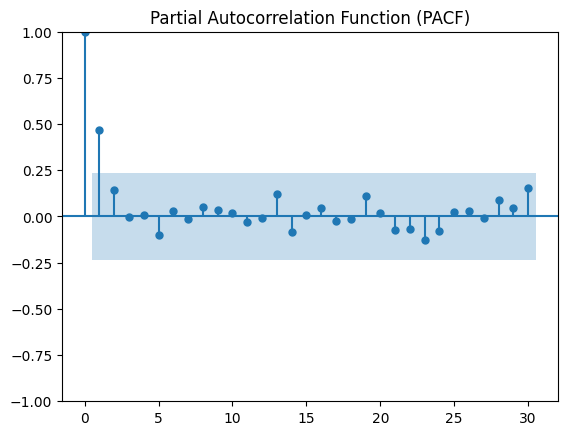

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(df2['average sentiment score'], lags=30, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
adf_test = adfuller(df2['average sentiment score'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Test Statistic: -7.591894305915613
p-value: 2.5185843224361306e-11


In [ ]:
daily_output_file = '/content/nasdq.csv'
nasdq = pd.read_csv(daily_output_file)
nasdq = nasdq.dropna()

In [ ]:
# Run ADF test on the correct column
adf_test = adfuller(nasdq['% Change.1'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Test Statistic: -6.766345845389027
p-value: 2.711044040339272e-09


<Figure size 1200x600 with 0 Axes>

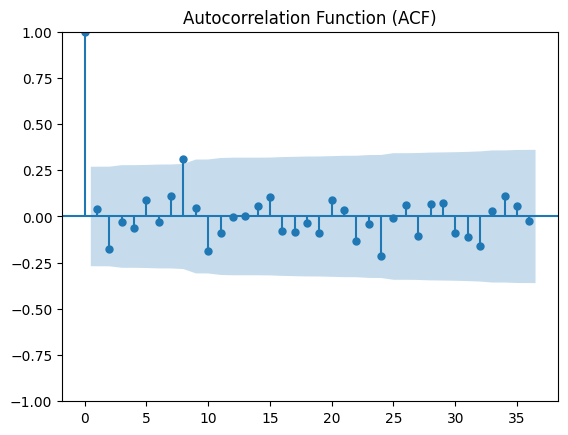

In [ ]:
plt.figure(figsize=(12, 6))
plot_acf(nasdq['% Change.1'], lags=36, title='Autocorrelation Function (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

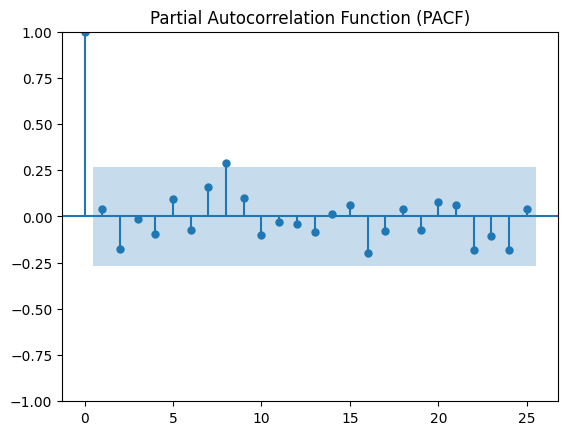

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(nasdq['% Change.1'], lags=25, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
vix = pd.read_excel('/content/vix.xlsx')
vix = vix.dropna()
adf_test = adfuller(vix['% Change.1'])
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Test Statistic: -8.770384816273838
p-value: 2.5304084551207883e-14




# **CAR Model**

In [ ]:
file_path ='/content/data515.xlsx'
data = pd.read_excel(file_path, parse_dates=["Date"]).set_index("Date")
data = data.sort_index().loc["2022-11-25":"2023-02-14"]

In [ ]:
data["ETF return"] = data["ETF return"] /100
data["NASDAQ return"] = data["NASDAQ return"] /100
data.head()

,NASDAQ return,ETF return
Date,,
2022-11-28,-0.015748,-0.020742
2022-11-29,-0.005907,-0.011126
2022-11-30,0.044189,0.010409
2022-12-01,0.001377,0.049128
2022-12-02,-0.001800,-0.004371


In [ ]:
from datetime import timedelta
# Load the sentiment CSV file
df_sentiment = pd.read_csv('/content/chatgpt_sentiment.csv')

# Convert full datetime
df_sentiment['datetime'] = pd.to_datetime(df_sentiment['date'])

# Adjust for after-hours (4 PM cutoff)
def adjust_for_after_hours(dt):
    if dt.time().hour >= 16:
        return (dt + timedelta(days=1)).date()
    else:
        return dt.date()

df_sentiment['adjusted_date'] = df_sentiment['datetime'].apply(adjust_for_after_hours)

# Create scores
label_to_score = {'positive': 1, 'neutral': 0, 'negative': -1}
df_sentiment['sentiment_score'] = df_sentiment['predicted_label'].map(label_to_score)
df_sentiment['continuous_score'] = df_sentiment['positive'] - df_sentiment['negative']

# Aggregate by adjusted_date
daily_sentiment = df_sentiment.groupby('adjusted_date').agg({
    'sentiment_score': 'mean',
    'continuous_score': 'mean',
    'Text': 'count'
}).rename(columns={'Text': 'message_count'}).reset_index().rename(columns={'adjusted_date': 'date'})



In [ ]:
data.reset_index(inplace=True)
data['date'] = data['Date'].dt.date

In [ ]:
merged = pd.merge(data, daily_sentiment, on='date', how='left')
merged.head()

,Date,NASDAQ return,ETF return,date,sentiment_score,continuous_score,message_count
0,2022-11-28,-0.015748,-0.020742,2022-11-28,NaN,NaN,NaN
1,2022-11-29,-0.005907,-0.011126,2022-11-29,NaN,NaN,NaN
2,2022-11-30,0.044189,0.010409,2022-11-30,NaN,NaN,NaN
3,2022-12-01,0.001377,0.049128,2022-12-01,0.252279,0.232547,3730.0
4,2022-12-02,-0.001800,-0.004371,2022-12-02,0.209062,0.194133,9093.0


In [ ]:
merged.fillna(0)
merged.dropna()

,Date,NASDAQ return,ETF return,date,sentiment_score,continuous_score,message_count
3,2022-12-01,0.001377,0.049128,2022-12-01,0.252279,0.232547,3730.0
4,2022-12-02,-0.001800,-0.004371,2022-12-02,0.209062,0.194133,9093.0
5,2022-12-05,-0.019323,-0.012770,2022-12-05,0.151740,0.143179,19428.0
6,2022-12-06,-0.020013,-0.029624,2022-12-06,0.131950,0.123710,23561.0
7,2022-12-07,-0.005115,-0.015889,2022-12-07,0.121797,0.115308,19236.0
8,2022-12-08,0.011342,0.024974,2022-12-08,0.108336,0.104275,16372.0
9,2022-12-09,-0.006980,0.010796,2022-12-09,0.130025,0.122448,17309.0
10,2022-12-12,0.012642,0.000292,2022-12-12,0.104789,0.099926,11876.0
11,2022-12-13,0.010162,0.032851,2022-12-13,0.106870,0.106474,12174.0
12,2022-12-14,-0.007543,-0.002655,2022-12-14,0.129683,0.126861,10809.0


In [ ]:
# Compute RMSE for CAR_3D model
merged = merged.dropna(subset=['CAR_3D', 'ETF return', 'NASDAQ return'])

# Estimate expected returns from market model again
X = sm.add_constant(merged['NASDAQ return'])
y = merged['ETF return']
car_model = sm.OLS(y, X).fit()
expected_returns = car_model.predict(X)

# Calculate residuals (abnormal returns)
abnormal_returns = y - expected_returns
rmse_car = np.sqrt(mean_squared_error(y, expected_returns))

print(f"RMSE (CAR Market Model): {rmse_car:.4f}")

RMSE (CAR Market Model): 0.0190


In [ ]:
def calculate_car(event_date, data, estimation_period=20, event_window=[0, 2]):
    try:
        # Check if event_date exists in data
        if event_date not in data.index:
            return np.nan

        event_idx = data.index.get_loc(event_date)

        # Estimation period (60 days before event)
        est_start = event_idx - estimation_period
        est_end = event_idx - 1

        if est_start < 0:  # Not enough data
            return np.nan

        estimation_data = data.iloc[est_start:est_end]

        # Market model regression (ETF Return = α + β * NASDAQ Return)
        X = sm.add_constant(estimation_data["NASDAQ return"])
        y = estimation_data["ETF return"]
        model = sm.OLS(y, X).fit()
        alpha, beta = model.params

        event_data = data.iloc[event_idx + event_window[0] : event_idx + event_window[1] + 1]
        event_data["Expected_Return"] = alpha + beta * event_data["NASDAQ return"]
        event_data["Abnormal_Return"] = event_data["ETF return"] - event_data["Expected_Return"]

        return event_data["Abnormal_Return"].sum()
    except Exception as e:
        print(f"Skipped {event_date}: {str(e)}")
        return np.nan
merged["CAR_3D"] = [calculate_car(date, merged) for date in merged.index]

<ipython-input-50-96788f206458>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data["Expected_Return"] = alpha + beta * event_data["NASDAQ return"]
<ipython-input-50-96788f206458>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_data["Abnormal_Return"] = event_data["ETF return"] - event_data["Expected_Return"]
<ipython-input-50-96788f206458>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [ ]:
merged.head()


,Date,NASDAQ return,ETF return,date,sentiment_score,continuous_score,message_count,CAR_3D
0,2022-11-28,-0.015748,-0.020742,2022-11-28,NaN,NaN,NaN,NaN
1,2022-11-29,-0.005907,-0.011126,2022-11-29,NaN,NaN,NaN,NaN
2,2022-11-30,0.044189,0.010409,2022-11-30,NaN,NaN,NaN,NaN
3,2022-12-01,0.001377,0.049128,2022-12-01,0.252279,0.232547,3730.0,NaN
4,2022-12-02,-0.001800,-0.004371,2022-12-02,0.209062,0.194133,9093.0,NaN


In [ ]:
file = '/content/market data.xlsx'
market = pd.read_excel(file)
market['date'] = pd.to_datetime(market['date'])
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
merged['date'] = pd.to_datetime(merged['date'])


In [ ]:
merged1 = pd.merge(merged, market,  on='date', how='left')

In [ ]:
merged1.head()


,Date,NASDAQ return,ETF return,date,sentiment_score,continuous_score,message_count,CAR_3D,vol,market
0,2022-11-28,-0.015748,-0.020742,2022-11-28,NaN,NaN,NaN,NaN,8.341463,-1.574801
1,2022-11-29,-0.005907,-0.011126,2022-11-29,NaN,NaN,NaN,NaN,-1.440792,-0.590663
2,2022-11-30,0.044189,0.010409,2022-11-30,NaN,NaN,NaN,NaN,-5.984468,4.418891
3,2022-12-01,0.001377,0.049128,2022-12-01,0.252279,0.232547,3730.0,NaN,-3.595724,0.137681
4,2022-12-02,-0.001800,-0.004371,2022-12-02,0.209062,0.194133,9093.0,NaN,-3.931452,-0.179964


In [ ]:
car_series = merged["CAR_3D"].dropna()
car_series = car_series[~np.isinf(car_series)]
print(merged["CAR_3D"].to_numpy())

[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan -0.00670529  0.02507136  0.01260499  0.00234262
  0.04357739  0.02700388  0.02342115  0.0060035  -0.01880553 -0.00097018
 -0.00942317 -0.0109339   0.01491714  0.00304286 -0.00153304  0.00387922
  0.03208653  0.00292423 -0.01040182 -0.01155025  0.0140814  -0.0056753
 -0.00440479  0.01629789  0.0377976   0.02096842 -0.04453764 -0.01727456
  0.00319025  0.01129396 -0.02327413 -0.03934057 -0.01066391 -0.00302419]


In [ ]:
adf_test = adfuller(car_series)
print("ADF Test Statistic:", adf_test[0])
print("p-value:", adf_test[1])

ADF Test Statistic: -4.241898453573729
p-value: 0.0005591799854329257


<Figure size 1200x600 with 0 Axes>

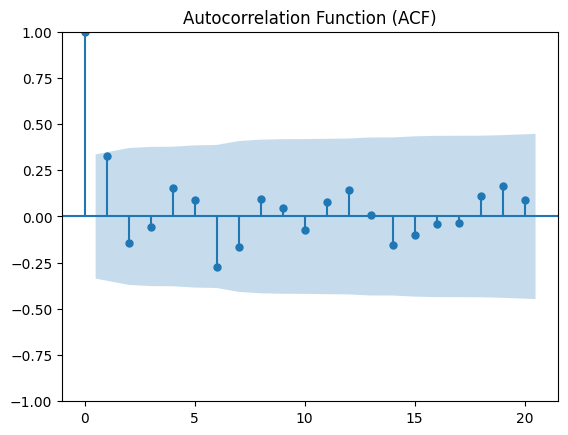

In [ ]:
#testing ACF and PACF to find which model to use
plt.figure(figsize=(12, 6))
plot_acf(car_series, lags=20, title='Autocorrelation Function (ACF)')
plt.show()

<Figure size 1200x600 with 0 Axes>

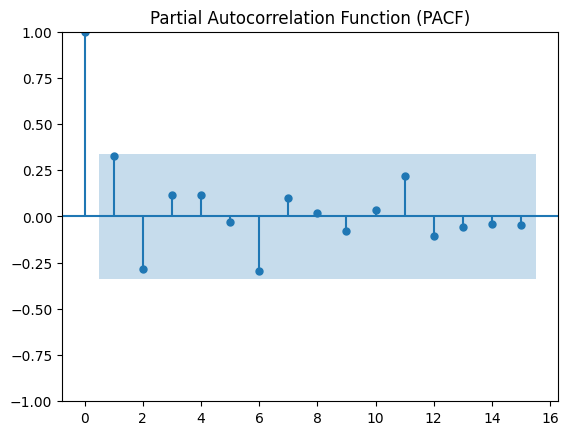

In [ ]:
plt.figure(figsize=(12, 6))
plot_pacf(car_series, lags=15, title='Partial Autocorrelation Function (PACF)')
plt.show()

In [ ]:
# Drop missing values
analysis_df = merged1.dropna(subset=['CAR_3D', 'sentiment_score', 'market', 'vol'])

# Define variables
endog = analysis_df['CAR_3D']
exog = analysis_df[['sentiment_score', 'market', 'vol']]

# Fit ARIMAX model
model = sm.tsa.ARIMA(endog, exog=exog, order=(1, 0, 0))
results = model.fit()

# Predict in-sample
pred = results.predict(start=0, end=len(endog)-1, exog=exog)

# Calculate RMSE
rmse_arimax = np.sqrt(mean_squared_error(endog, pred))

# Display results
print(results.summary())
print(f"RMSE (ARIMAX 1,0,0): {rmse_arimax:.4f}")

                               SARIMAX Results                                
Dep. Variable:                 CAR_3D   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  84.405
Date:                Tue, 15 Apr 2025   AIC                           -156.810
Time:                        09:50:24   BIC                           -148.206
Sample:                             0   HQIC                          -154.005
                                 - 31                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0383      0.017     -2.189      0.029      -0.073      -0.004
sentiment_score     0.3327      0.140      2.370      0.018       0.058       0.608
market              0.0057      

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
model = sm.tsa.ARIMA(endog, exog=exog, order=(0, 0, 0))
results = model.fit()

print(results.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 CAR_3D   No. Observations:                   31
Model:                          ARIMA   Log Likelihood                  84.252
Date:                Tue, 15 Apr 2025   AIC                           -158.504
Time:                        08:44:17   BIC                           -151.334
Sample:                             0   HQIC                          -156.167
                                 - 31                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0383      0.017     -2.286      0.022      -0.071      -0.005
sentiment_score     0.3327      0.136      2.440      0.015       0.065       0.600
market              0.0057      

# **Robustness Checks**

In [ ]:
# Ensure merged1 exists and has no missing required values
analysis_df = merged1.dropna(subset=['CAR_3D', 'sentiment_score', 'market', 'vol'])
endog = analysis_df['CAR_3D']
full_exog = analysis_df[['sentiment_score', 'market', 'vol']]

# 1. Lag Sensitivity: Try different ARIMA (p,d,q) orders
orders = [(1, 0, 0), (2, 0, 0), (1, 0, 1), (2, 0, 2)]
for order in orders:
    try:
        model = sm.tsa.ARIMA(endog, exog=full_exog, order=order)
        results = model.fit()
        print(f"\n--- ARIMAX Order {order} ---")
        print(results.summary())
    except Exception as e:
        print(f"Failed ARIMAX Order {order}: {e}")

# 2. Alternative Specifications: Different sets of regressors
exog_sets = {
    'All Vars': ['sentiment_score', 'market', 'vol'],
    'No Sentiment': ['market', 'vol'],
    'No Market': ['sentiment_score', 'vol'],
    'Sentiment Only': ['sentiment_score']
}

for label, exog_cols in exog_sets.items():
    try:
        print(f"\n--- ARIMAX with {label} ---")
        exog = analysis_df[exog_cols]
        model = sm.tsa.ARIMA(endog, exog=exog, order=(1, 0, 0))
        results = model.fit()
        print(results.summary())
    except Exception as e:
        print(f"Failed model with {label}: {e}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot


--- ARIMAX Order (1, 0, 0) ---
                               SARIMAX Results                                
Dep. Variable:                 CAR_3D   No. Observations:                   31
Model:                 ARIMA(1, 0, 0)   Log Likelihood                  84.405
Date:                Tue, 15 Apr 2025   AIC                           -156.810
Time:                        08:44:17   BIC                           -148.206
Sample:                             0   HQIC                          -154.005
                                 - 31                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0383      0.017     -2.189      0.029      -0.073      -0.004
sentiment_score     0.3327      0.140      2.370      0.018       0.058       0.608


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv


--- ARIMAX Order (1, 0, 1) ---
                               SARIMAX Results                                
Dep. Variable:                 CAR_3D   No. Observations:                   31
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  86.489
Date:                Tue, 15 Apr 2025   AIC                           -158.978
Time:                        08:44:17   BIC                           -148.940
Sample:                             0   HQIC                          -155.706
                                 - 31                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0332      0.019     -1.783      0.075      -0.070       0.003
sentiment_score     0.2895      0.156      1.860      0.063      -0.016       0.595


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of


--- ARIMAX Order (2, 0, 2) ---
                               SARIMAX Results                                
Dep. Variable:                 CAR_3D   No. Observations:                   31
Model:                 ARIMA(2, 0, 2)   Log Likelihood                  86.834
Date:                Tue, 15 Apr 2025   AIC                           -155.668
Time:                        08:44:18   BIC                           -142.762
Sample:                             0   HQIC                          -151.461
                                 - 31                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0380      0.015     -2.487      0.013      -0.068      -0.008
sentiment_score     0.3341      0.132      2.527      0.012       0.075       0.593


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)



--- Potential Outliers Detected (|z| > 2) ---
[23 25]
Dates of outliers: [44, 46]


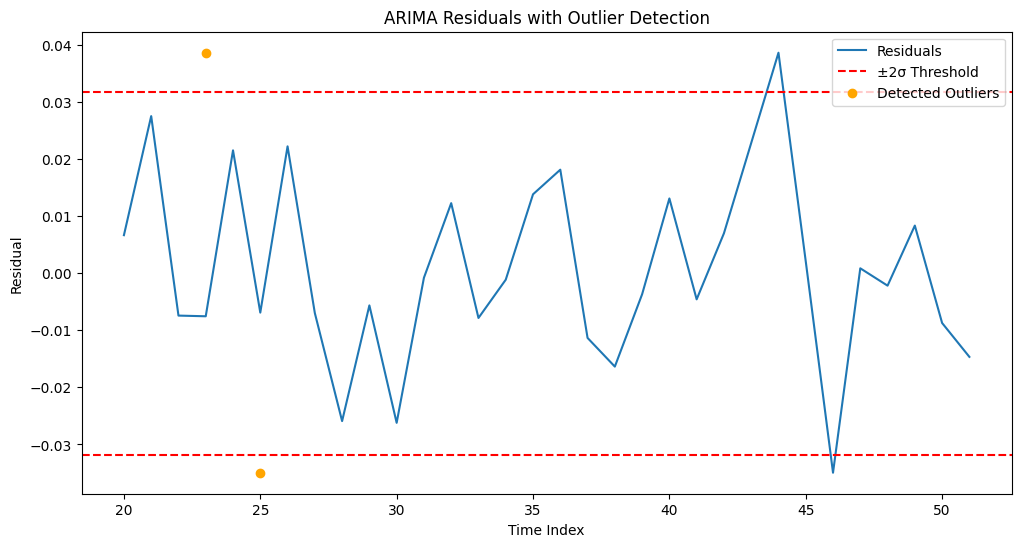

In [ ]:
# Use best model residuals (from ARIMAX(1,0,0) with full vars)
model = sm.tsa.ARIMA(endog, exog=full_exog, order=(1, 0, 0))
results = model.fit()
residuals = results.resid

# Identify outliers using z-score method (like Additive Outliers)
threshold = 2  # 2 standard deviations
outlier_indices = np.where(np.abs((residuals - residuals.mean()) / residuals.std()) > threshold)[0]

print("\n--- Potential Outliers Detected (|z| > 2) ---")
print(outlier_indices)
print("Dates of outliers:", analysis_df.iloc[outlier_indices].index.to_list())

# Plot residuals and highlight outliers
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Residuals')
plt.axhline(y=threshold * np.std(residuals), color='red', linestyle='--', label='±2σ Threshold')
plt.axhline(y=-threshold * np.std(residuals), color='red', linestyle='--')
plt.scatter(outlier_indices, residuals.iloc[outlier_indices], color='orange', label='Detected Outliers')
plt.title("ARIMA Residuals with Outlier Detection")
plt.xlabel("Time Index")
plt.ylabel("Residual")
plt.legend()
plt.show()


# **Forecast Visualization**

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


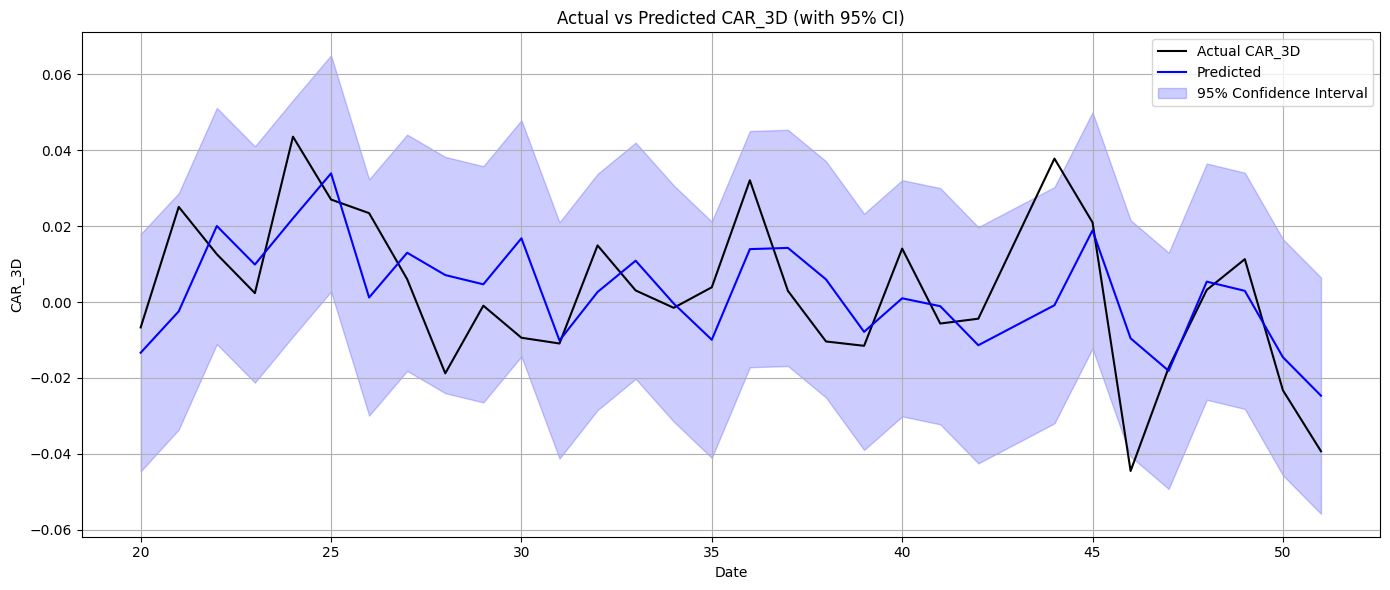

In [ ]:
# Fit model again with best config (ARIMAX(1,0,0), all exogenous vars)
model = sm.tsa.ARIMA(endog, exog=full_exog, order=(1, 0, 0))
results = model.fit()

# Get in-sample predictions and confidence intervals
pred = results.get_prediction(start=0, end=len(endog)-1, exog=full_exog, dynamic=False)
pred_mean = pred.predicted_mean
conf_int = pred.conf_int(alpha=0.05)  # 95% CI

# Plot
plt.figure(figsize=(14, 6))
plt.plot(endog.index, endog, label='Actual CAR_3D', color='black')
plt.plot(endog.index, pred_mean, label='Predicted', color='blue')

# Confidence interval bounds
plt.fill_between(endog.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                 color='blue', alpha=0.2, label='95% Confidence Interval')

plt.title('Actual vs Predicted CAR_3D (with 95% CI)')
plt.xlabel('Date')
plt.ylabel('CAR_3D')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!pip install arch

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0003812. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 CAR_3D   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                85.6004
Distribution:                  Normal   AIC:                          -163.201
Method:            Maximum Likelihood   BIC:                          -157.095
                                        No. Observations:                   34
Date:                Tue, Apr 15 2025   Df Residuals:                       33
Time:                        08:44:29   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.4367e-03  3.441e-03      0.708      0.479 

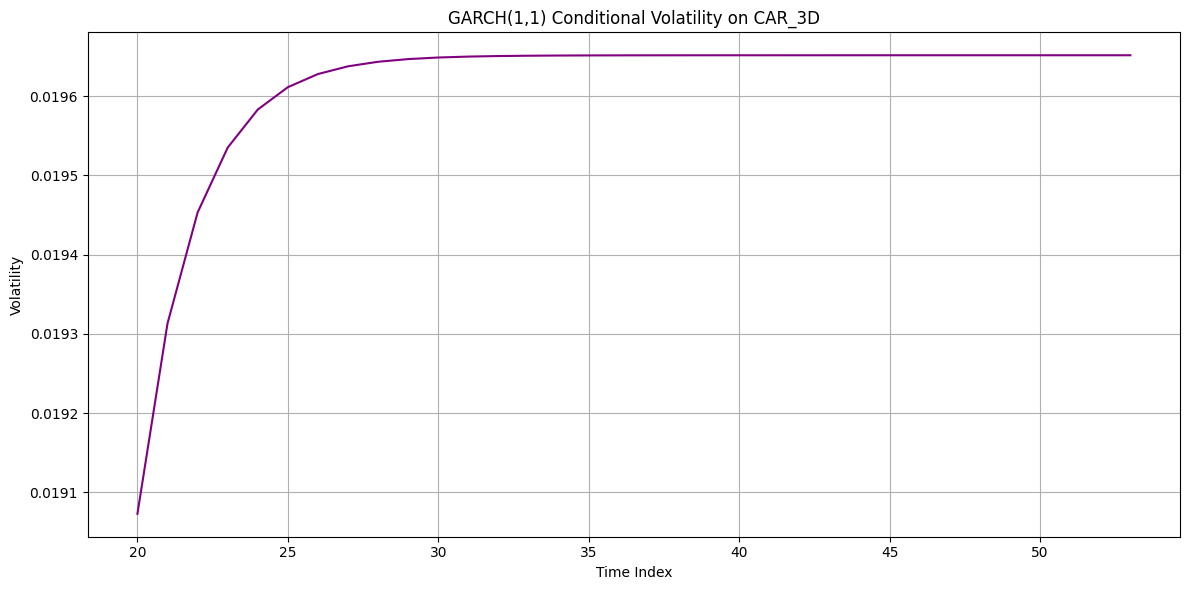

RMSE of GARCH model: 0.019524241002705157


In [ ]:
from arch import arch_model

# === GARCH Modeling on CAR_3D ===

# Clean CAR_3D series
car_series = merged1['CAR_3D'].dropna()
car_series = car_series[~np.isinf(car_series)]

# Fit a GARCH(1,1) model (mean='Constant' assumes constant mean)
garch_model = arch_model(car_series, vol='GARCH', p=1, q=1, mean='Constant', dist='normal')
garch_results = garch_model.fit(disp='off')

# Print summary
print(garch_results.summary())

# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_results.conditional_volatility, color='purple')
plt.title('GARCH(1,1) Conditional Volatility on CAR_3D')
plt.xlabel('Time Index')
plt.ylabel('Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error
import numpy as np

# Get the fitted values (model's predictions for the mean return)
fitted_values = garch_results.params['mu']  # constant mean

# Create an array of predicted means (same shape as actual)
predicted = np.full_like(car_series, fill_value=fitted_values)

# Actual values
actual = car_series.values

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
print("RMSE of GARCH model:", rmse)